In [19]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

In [20]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_231/func_0/'

In [21]:
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220824_142240.h5')
f = h5py.File(closed_loop_h5_file, 'r')
start_thetas = f.attrs['start_theta']

In [4]:
#list(f['trials']['000'].keys())

In [6]:
# len(start_thetas)

In [22]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 2000

behavior_traces = {}
mean_trace = {}
sem_trace = {}
#for angle in [0,180]:
for behavior in ['Z', 'h', 'Y']:
    behavior_traces_,mean_trace,sem_trace = extract_traces(fictrac,
                                                          stimulus_start_times,
                                                          pre_window,
                                                          post_window,
                                                          behavior)
    behavior_traces[behavior] = behavior_traces_

loading photodiode data... done


array([[ 0.00000000e+00,  2.07945364e+00,  4.20242439e+00, ...,
        -3.39375981e+00, -3.76190748e+00, -4.14926545e+00],
       [ 0.00000000e+00, -2.78374463e-01, -5.42752738e-01, ...,
         2.44019918e+02,  2.43309383e+02,  2.42666557e+02],
       [ 0.00000000e+00, -4.37768119e-01, -8.36790210e-01, ...,
        -4.86780606e+01, -4.77413130e+01, -4.68141972e+01],
       ...,
       [ 0.00000000e+00,  1.63885848e+00,  3.22541159e+00, ...,
         2.61303466e+02,  2.62808103e+02,  2.64376312e+02],
       [ 0.00000000e+00,  1.72628149e+00,  3.46738464e+00, ...,
        -3.01350470e+02, -2.99961401e+02, -2.98761600e+02],
       [ 0.00000000e+00,  3.20454455e-01,  3.32850591e-01, ...,
         8.95391669e+01,  9.06879029e+01,  9.18479610e+01]])

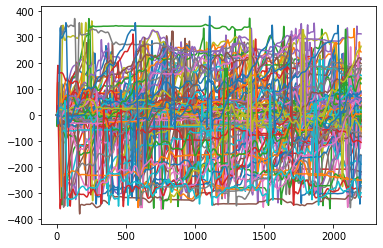

In [23]:
# The heading of the fly
behavior_traces_zero_start = []
for trace in behavior_traces['h']:
    behavior_traces_zero_start.append(trace-trace[0])# the delta of heading after the bar shows up
behavior_traces_zero_start = np.asarray(behavior_traces_zero_start)
behavior_traces['h_zero'] = behavior_traces_zero_start
# The delta heading of fly
for trace in behavior_traces_zero_start:
    plt.plot(trace)

np.asarray(behavior_traces_zero_start)

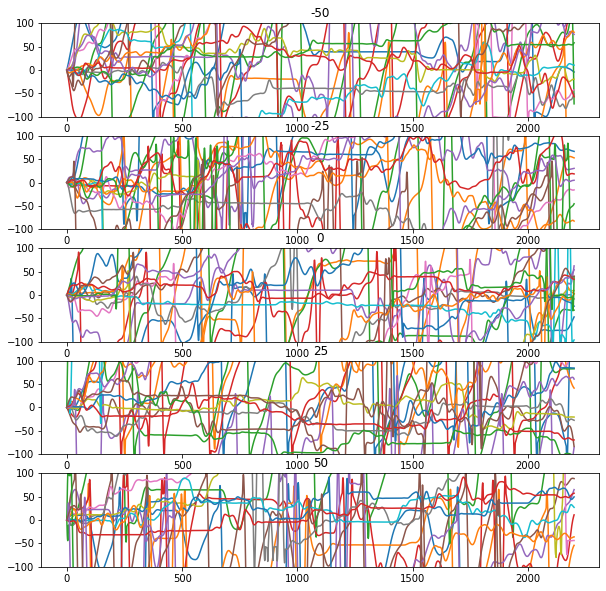

In [24]:
plt.figure(figsize=(10,10))

trial_traces = []
fwd_traces = []
ang_traces = []
trial_idss = []
for i, theta in enumerate(np.unique(start_thetas)):
    trial_ids = np.where(start_thetas[:-1] == theta)[0] #-1 to remove last trial that doesn't exist
    trial_idss.append(trial_ids)
    plt.subplot(5,1,i+1)
#     plt.plot(np.mean(behavior_traces[trial_ids,:],axis=0))
    trial_traces.append(behavior_traces['h_zero'][trial_ids,:])
    fwd_traces.append(behavior_traces['Y'][trial_ids,:])
    ang_traces.append(behavior_traces['Z'][trial_ids,:])
    
    for trial in trial_ids:
        plt.plot(behavior_traces_zero_start[trial,:])
    plt.ylim(-100,100)
    plt.title(theta)


In [8]:
### Unifrom the units and Make then intigers###
#stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers

In [9]:
#stimulus_start_times

In [10]:

# # Check point 1 : 20s stimulus duration + 2s ITI
# plt.figure(figsize=(10,10))
# for i in range(len(stimulus_start_times)):


In [11]:
# ### Get Metadata ###
# stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
# print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
#starts_angle = {}
#for angle in [0,180]:
    #starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
#print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
#starts_angle_ms = {}
#for angle in [0,180]:
    #starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

In [12]:
####################
### Prep Fictrac ###
####################

# fictrac_path = os.path.join(func_path, 'fictrac')
# fictrac_raw = brainsss.load_fictrac(fictrac_path)

# fps = 100
# resolution = 10 #desired resolution in ms
# expt_len = fictrac_raw.shape[0]/fps*1000
# behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
# fictrac = {}
# for behavior in behaviors:
#     if behavior == 'dRotLabY': short = 'Y'
#     elif behavior == 'dRotLabZ': short = 'Z'
#     elif behavior == 'heading': short = 'h'
#     fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
#     fictrac[short] = np.roll(fictrac[short],400) # misalignment is corrected
# fictrac_timestamps = np.arange(0,expt_len,resolution)

In [13]:
# fictrac['h'] = np.rad2deg(fictrac['h'])

In [14]:
# plt.plot(fictrac['h'][:1000])
# plt.plot(fictrac['Z'][:1000])

# negative Z means right turn
# right turn caused decrease
# So, negative heading means the fly is turning to right
# for flystim, negative bar is to the left
# So, if a negative bar, we would expect positive heading

In [15]:
# plt.plot(np.rad2deg(fictrac['h']))

In [16]:
# plt.plot(fictrac['Y'])

In [17]:
# len(fictrac['Y'])

In [18]:
# def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
#     traces = []
#     for i in range(len(stim_times)):
#         trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
#         if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
#             traces.append(trace)
#     traces = np.asarray(traces)
#     mean_trace = np.mean(traces,axis=0)
#     sem_trace = scipy.stats.sem(traces,axis=0)
#     return traces, mean_trace, sem_trace
# ###########################################
# ### Extract Stimulus Triggered Behavior ###
# ###########################################

# pre_window = 200
# post_window = 2000

# behavior_traces = {}
# mean_trace = {}
# sem_trace = {}
# #for angle in [0,180]:
# for behavior in ['Z', 'h', 'Y']:
#     behavior_traces_,mean_trace,sem_trace = extract_traces(fictrac,
#                                                           stimulus_start_times,
#                                                           pre_window,
#                                                           post_window,
#                                                           behavior)
#     behavior_traces[behavior] = behavior_traces_

In [19]:
# # The heading of the fly
# behavior_traces_zero_start = []
# for trace in behavior_traces['h']:
#     behavior_traces_zero_start.append(trace-trace[0])# the delta of heading after the bar shows up
# behavior_traces_zero_start = np.asarray(behavior_traces_zero_start)
# behavior_traces['h_zero'] = behavior_traces_zero_start

In [20]:
# behavior_traces_zero_start.shape

In [21]:
# # The delta heading of fly
# for trace in behavior_traces_zero_start:
#     plt.plot(trace)

In [22]:
# def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
#     traces = []
#     for i in range(len(stim_times)):
#         trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
#         if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
#             traces.append(trace)
#     traces = np.asarray(traces)
#     mean_trace = np.mean(traces,axis=0)
#     sem_trace = scipy.stats.sem(traces,axis=0)
#     return traces, mean_trace, sem_trace

In [25]:
stim_times = stimulus_start_times
i=0
trace = fictrac['h'][stim_times[i]-pre_window:stim_times[i]+post_window]

In [26]:
fictrac['h']

array([287.070647  , 287.47582889, 287.96881503, ..., 286.28387389,
       286.45614933, 286.72170471])

In [27]:
stim_times[i]+post_window

2706

In [28]:
stim_times[i]-pre_window

506

In [27]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

# pre_window = 200
# post_window = 2000

# behavior_traces = {}
# mean_trace = {}
# sem_trace = {}
# #for angle in [0,180]:
# for behavior in ['Z', 'h', 'Y']:
#     behavior_traces_,mean_trace,sem_trace = extract_traces(fictrac,
#                                                           stimulus_start_times,
#                                                           pre_window,
#                                                           post_window,
#                                                           behavior)
#     behavior_traces[behavior] = behavior_traces_

In [28]:
#behavior_traces['Z'].shape

In [29]:
#len(stimulus_start_times)

In [30]:
#for i, theta in enumerate(np.unique(start_thetas)):
    #print(i)

In [31]:
#np.asarray(behavior_traces_zero_start)

In [32]:
#behavior_traces['Y'].shape

In [33]:
#behavior_traces['Y'].shape

In [34]:
# fps = 100
# resolution = 10 #desired resolution in ms
# expt_len = fictrac_raw.shape[0]/fps*1000
# behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
# fictrac = {}
# for behavior in behaviors:
#     if behavior == 'dRotLabY': short = 'Y'
#     elif behavior == 'dRotLabZ': short = 'Z'
#     elif behavior == 'heading': short = 'h'
#     fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
#     fictrac[short] = np.roll(fictrac[short],400) # misalignment is corrected
# fictrac_timestamps = np.arange(0,expt_len,resolution)

# plt.figure(figsize=(10,10))

# trial_traces = []
# fwd_traces = []
# ang_traces = []
# for i, theta in enumerate(np.unique(start_thetas)):
#     trial_ids = np.where(start_thetas[:-1] == theta)[0] #-1 to remove last trial that doesn't exist

#     plt.subplot(5,1,i+1)
# #     plt.plot(np.mean(behavior_traces[trial_ids,:],axis=0))
#     trial_traces.append(behavior_traces['h_zero'][trial_ids,:])
#     fwd_traces.append(behavior_traces['Y'][trial_ids,:])
#     ang_traces.append(behavior_traces['Z'][trial_ids,:])
    
#     for trial in trial_ids:
#         plt.plot(behavior_traces_zero_start[trial,:])
#     plt.ylim(-100,100)
#     plt.title(theta)

In [29]:
neg_50 = np.asarray(trial_traces)[0,:,:]

In [30]:
neg_50.shape

(16, 2200)

In [31]:
np.shape(trial_traces[0])

(16, 2200)

In [32]:
len(neg_50[1])

2200

In [39]:
for i in range(len(neg_50[m,:]))

SyntaxError: invalid syntax (<ipython-input-39-da1866bd28b3>, line 1)

In [40]:
#trial_val = np.zeros(np.shape(neg_50[0]))
# trial_fixation = []
# for m in range(16):
#     fixation = []
#     for n in range(len(neg_50[m,:])):
#         if -(-50+10) <= n <= -(-50-10):
#            fixation.append(n)
#     percentage_fix = len(fixation)/len(neg_50[1])
#     #trial_val[m] = percentage_fix  
#     trial_fixation.append(percentage_fix)
# trial_fixation

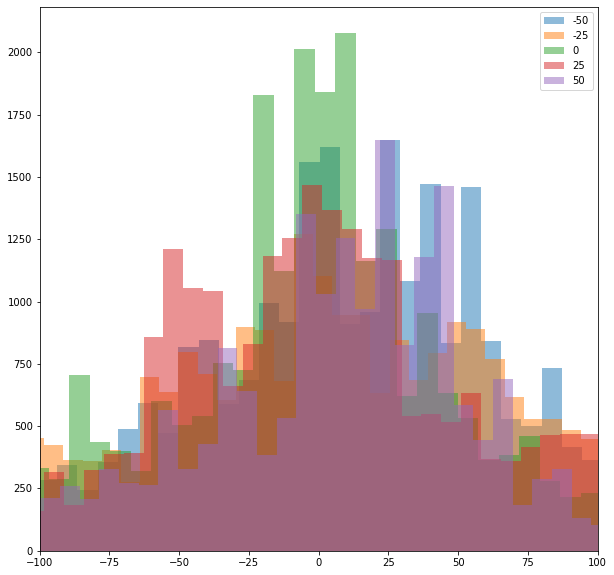

In [33]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.hist(trial_traces[i].flatten(),bins=100,alpha=.5,label=np.unique(start_thetas)[i]);
plt.xlim(-100,100)
plt.legend()

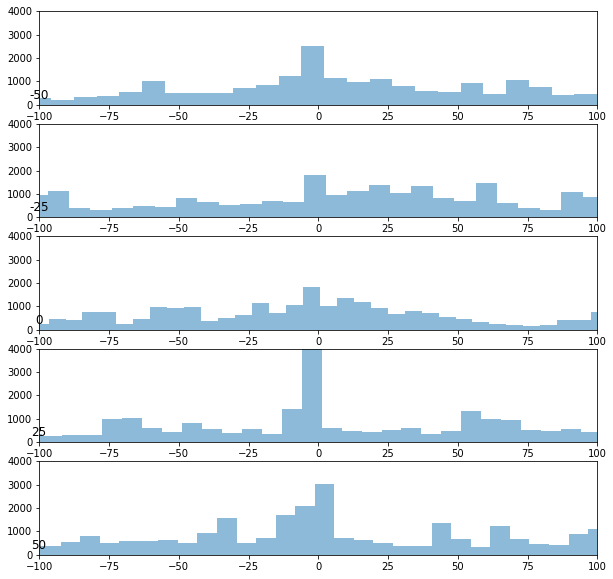

In [42]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.hist(trial_traces[i].flatten(),bins=100,alpha=.5,label=np.unique(start_thetas)[i]);
    plt.xlim(-100,100)
    plt.ylim(0,4000)
    plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

In [43]:
trial_traces[1].shape

(16, 2200)

In [44]:
behavior_traces_zero_start.shape

(80, 2200)

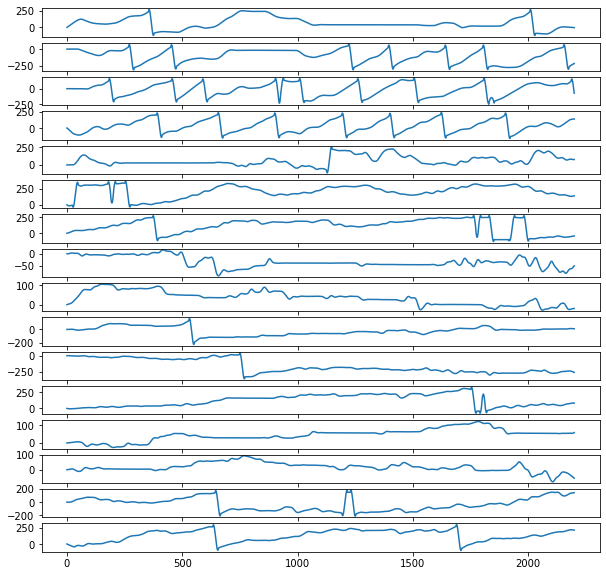

In [34]:
### -50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(trial_traces[0][i])


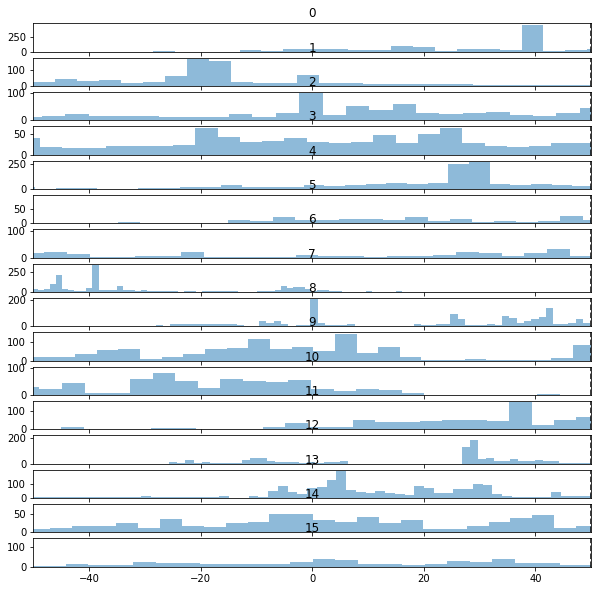

In [35]:
### -50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[0][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(50,color='k',linestyle='--')

In [36]:
trial_traces[0][2,:].flatten().shape

(2200,)

In [37]:
pre_window + post_window

2200

In [38]:
trial_traces[0].shape

(16, 2200)

In [39]:
import seaborn as sns

In [40]:
#plt.scatter(trial_traces[0][2,:],2200)

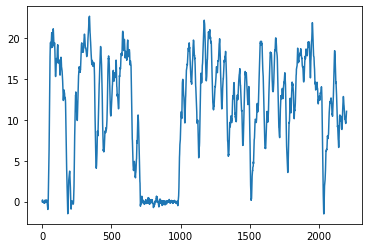

In [41]:
plt.plot(fwd_traces[0][1,:])

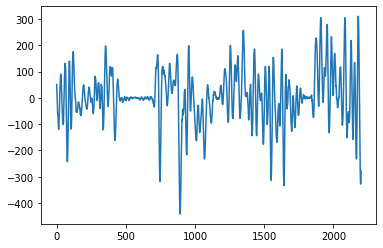

In [53]:
plt.plot(ang_traces[0][1,:])

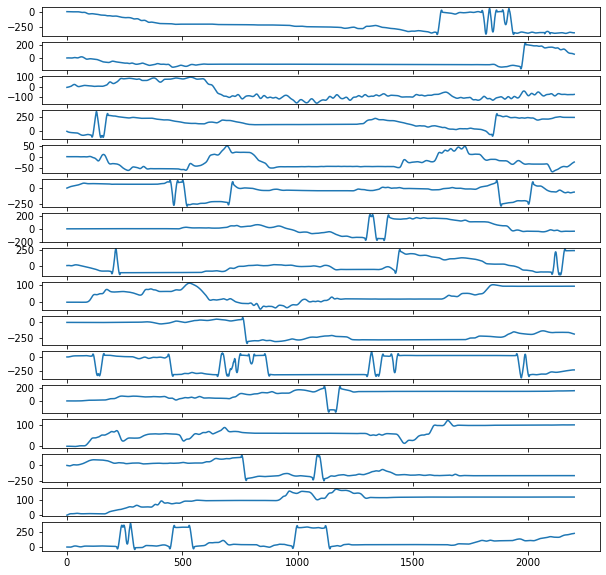

In [54]:
### -25 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(trial_traces[1][i])

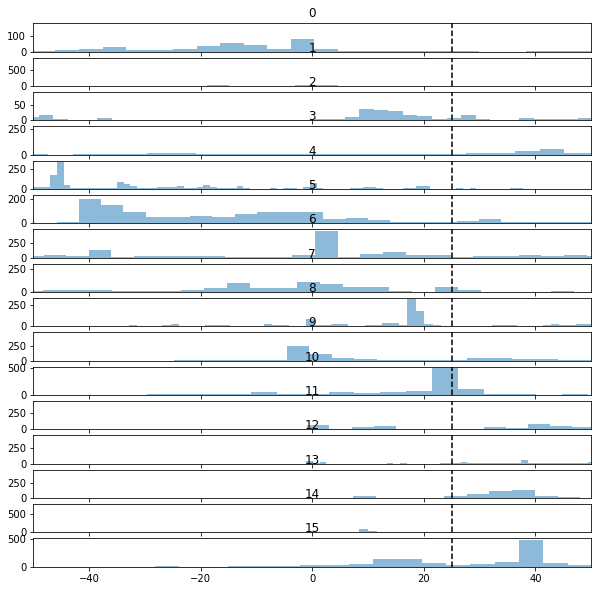

In [55]:
### -25 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[1][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(25,color='k',linestyle='--')
    #plt.ylim(0,4000)
    #plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

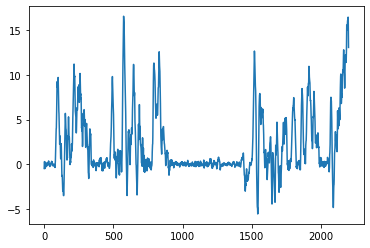

In [56]:
plt.plot(fwd_traces[1][4,:])

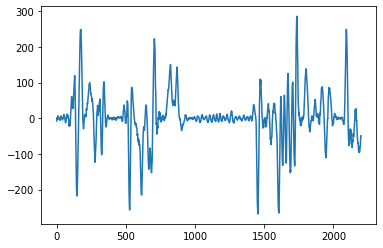

In [57]:
plt.plot(ang_traces[1][4,:])

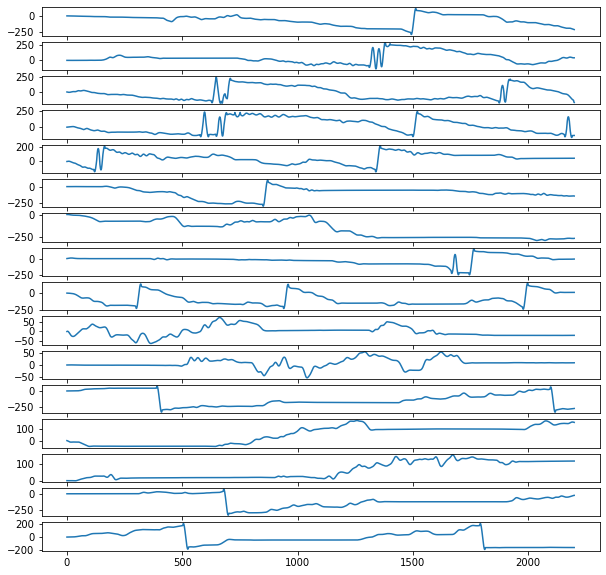

In [58]:
### 0 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(trial_traces[2][i])

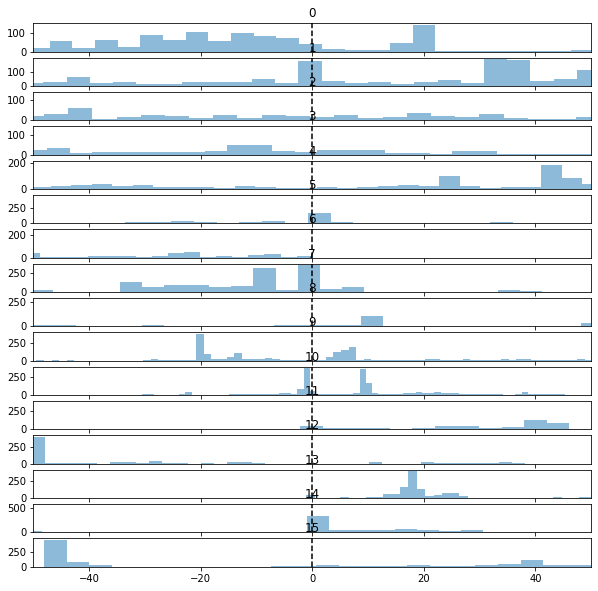

In [59]:
### 0 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[2][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(0,color='k',linestyle='--')
    #plt.ylim(0,4000)
    #plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

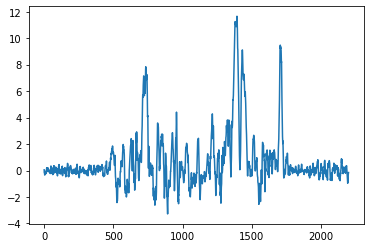

In [60]:
plt.plot(fwd_traces[2][10,:])

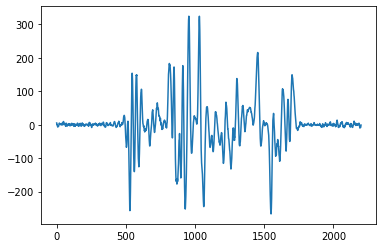

In [61]:
plt.plot(ang_traces[2][10,:])

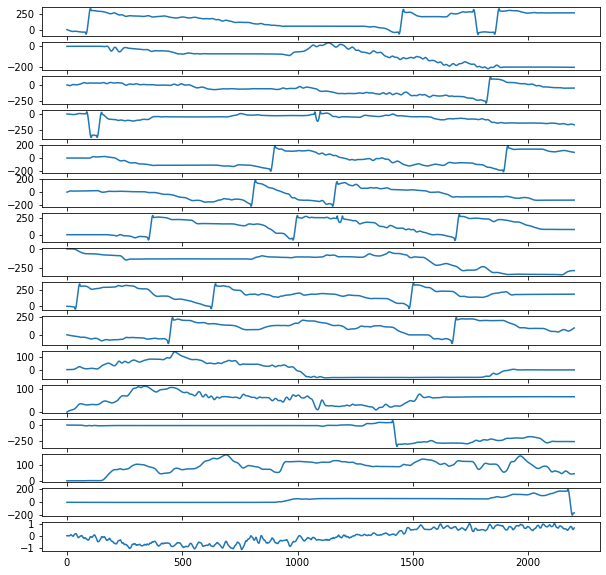

In [62]:
### 25 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(trial_traces[3][i])

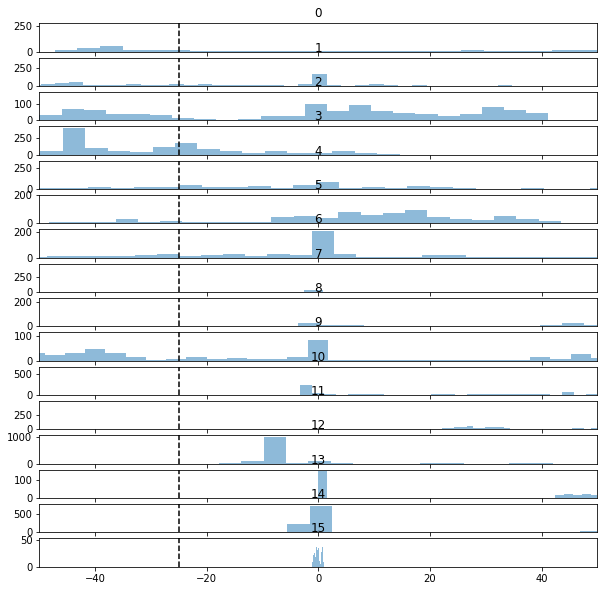

In [63]:
### 25 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[3][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(-25,color='k',linestyle='--')
    #plt.ylim(0,4000)
    #plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

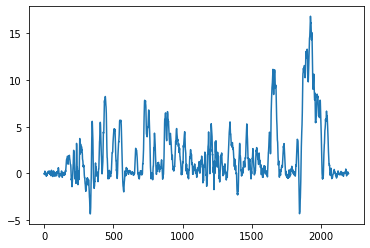

In [64]:
plt.plot(fwd_traces[3][6,:])

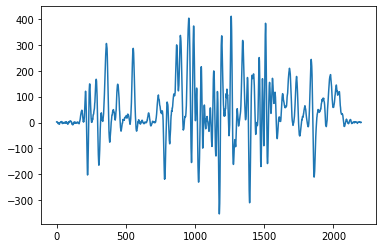

In [65]:
plt.plot(ang_traces[3][6,:])

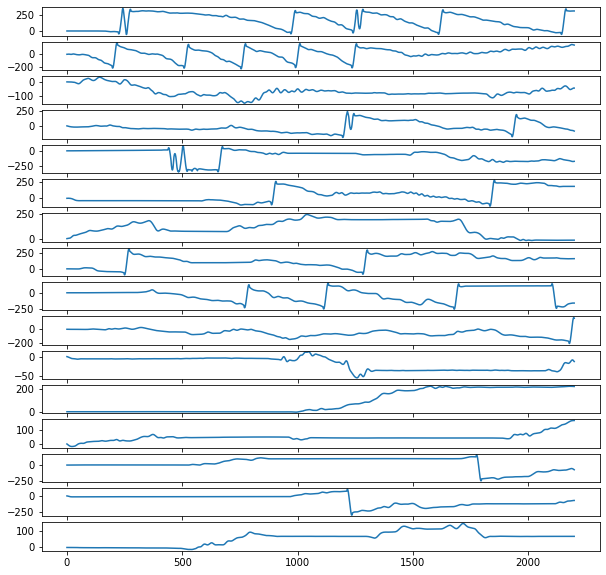

In [66]:
### 50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(trial_traces[4][i])

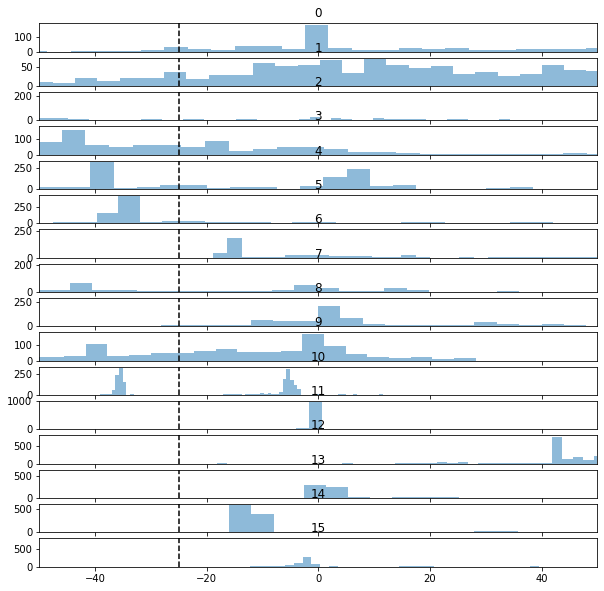

In [67]:
### 50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[4][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(-25,color='k',linestyle='--')
    #plt.ylim(0,4000)
    #plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

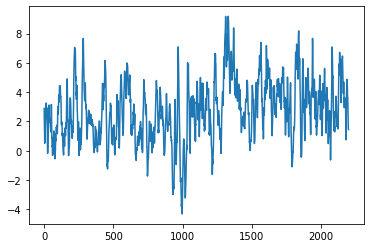

In [68]:
plt.plot(fwd_traces[4][1,:])


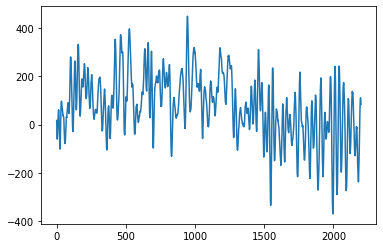

In [69]:
plt.plot(ang_traces[4][1,:])

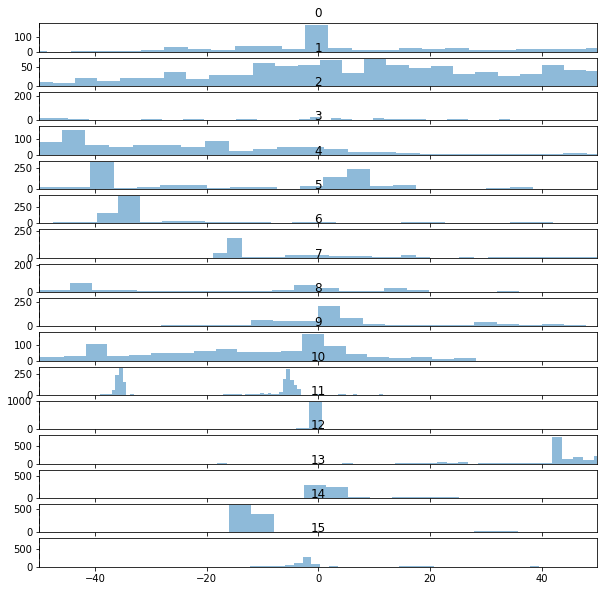

In [70]:
### 50 ###
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.hist(trial_traces[4][i,:].flatten(),bins=100,alpha=.5);
    plt.xlim(-50,50)
    plt.title(i)
    plt.axvline(-50,color='k',linestyle='--')
    #plt.ylim(0,4000)
    #plt.title(np.unique(start_thetas)[i],x=-.001,y=-.001)
#plt.legend()

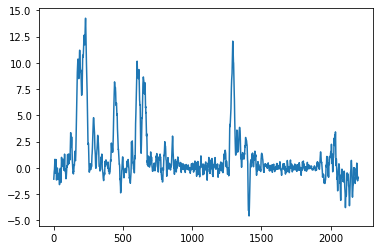

In [71]:
plt.plot(fwd_traces[1][10,:])

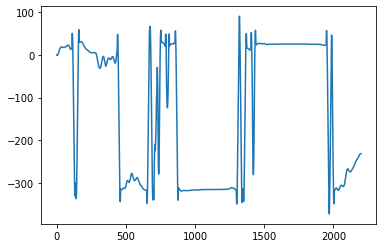

In [72]:
plt.plot(trial_traces[1][10,:])

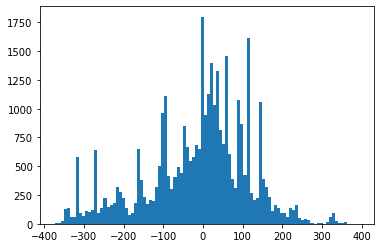

In [73]:
plt.hist(trial_traces[1].flatten(),bins=100);

In [74]:
skew = []
for i in range(5):
    skew.append(np.sum(trial_traces[i].flatten() > 0)/np.sum(trial_traces[i].flatten() < 0))

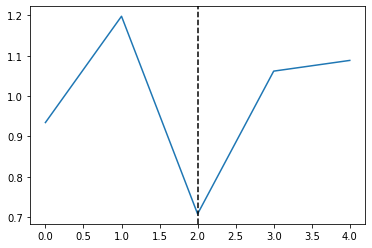

In [75]:
plt.plot(skew)
plt.axvline(2,color='k',linestyle='--')

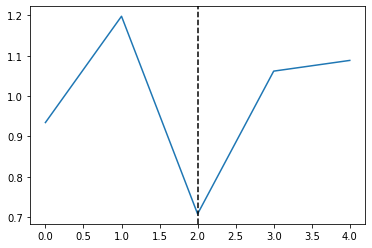

In [76]:
plt.plot(skew)
plt.axvline(2,color='k',linestyle='--')

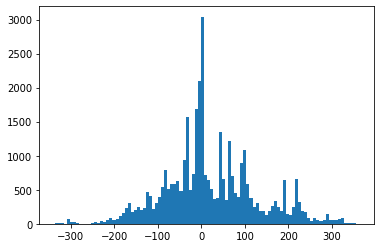

In [77]:
plt.hist(trial_traces[4].flatten(),bins=100);

In [78]:
np.where(start_thetas == -50)[0]

array([ 2,  9, 13, 16, 23, 27, 30, 38, 42, 49, 52, 59, 61, 69, 73, 76])

In [79]:
# plt.figure(figsize=(10,10))
# for i in range(behavior_traces.shape[0]):
#     plt.plot(behavior_traces[i,:])

In [80]:
diffs = behavior_traces[:,200] - behavior_traces[:,220]

TypeError: unhashable type: 'slice'

In [81]:
# plt.figure(figsize=(10,10))
# for i in range(184):
#     plt.plot([0,1],[behavior_traces[i,200],behavior_traces[i,220]],color='k')

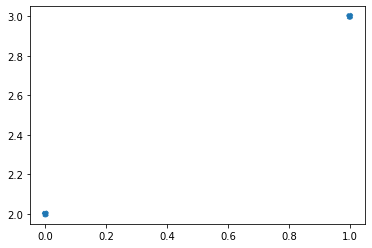

In [82]:
plt.scatter(x=[0,1],y=[2,3],linestyle='--')

In [83]:
# plt.figure(figsize=(10,10))
# plt.hist(diffs,bins=50);

In [84]:
# plt.figure(figsize=(10,10))
# y=0
# for i in range(184):
#     if behavior_traces[i,200] > 5:
#         y+=1
#         plt.plot(behavior_traces[i,:])
# for line in [200,275]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)

In [85]:
y

NameError: name 'y' is not defined

In [86]:
# plt.figure(figsize=(10,10))
# plt.plot(mean_trace,color='k',linewidth=3)
# plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
# for line in [200,275]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)

In [87]:
# plt.figure(figsize=(10,10))

# for angle,color in zip([0,180],['blue','red']):
#     plt.plot(mean_trace[angle],color=color,linewidth=3)
#     plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [88]:
# #####################################
# ### Extract Visually Evoked Turns ###
# #####################################

# ve_turns = {}
# ve_turn_times = {}
# for angle,direction in zip([0,180],['neg','pos']):
#     ve_turns[angle], ve_turn_times[angle] = brainsss.get_visually_evoked_turns(behavior_traces[angle],
#                                                                       start=250, 
#                                                                       stop=300, 
#                                                                       r_thresh=.3, 
#                                                                       av_thresh=50, 
#                                                                       stim_times=starts_angle_ms[angle],
#                                                                       expected_direction=direction)

In [89]:
# fig = plt.figure(figsize=(10,10))

# plt.subplot(211)
# plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)
    
# plt.subplot(212)
# plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)

In [90]:
# plt.figure(figsize=(10,10))

# for angle,color in zip([0,180],['blue','red']):
#     mean_ve_trace = np.mean(ve_turns[angle],axis=0)
#     sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
#     plt.plot(mean_ve_trace,color=color,linewidth=3)
#     plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)
    

In [91]:
# def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
#     amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
#     indicies = np.argsort(amount_of_behavior)
#     top_x_indicies = indicies[:num_traces_to_return]
#     return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [92]:
# ve_no_turns = {}
# ve_no_turn_times = {}
# for angle in [0,180]:
#     ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
#                                   start=250,
#                                   stop=300,
#                                   num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
#                                   stim_times=starts_angle_ms[angle])

In [93]:
# fig = plt.figure(figsize=(10,10))

# plt.subplot(211)
# plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)
    
# plt.subplot(212)
# plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)

In [94]:
# plt.figure(figsize=(10,10))

# for angle,color in zip([0,180],['blue','red']):
#     mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
#     sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
#     plt.plot(mean_ve_trace,color=color,linewidth=3)
#     plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
# for line in [200,250,300]:
#     plt.axvline(line,color='k',linestyle='--',lw=2)
    
# plt.ylim(-50,50)

# manual behavior corr

In [1]:
os.listdir(func_path)

NameError: name 'os' is not defined

In [ ]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [97]:
neural_slice = neural[:,:,20,:]

In [98]:
time_average = np.mean(neural,axis=(0,1,2))

In [99]:
time_average.shape

(3384,)

(1300.0, 1700.0)

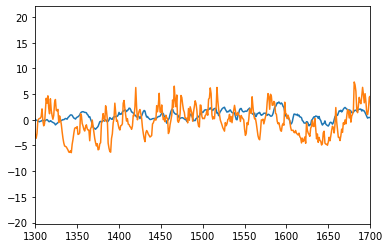

In [100]:
plt.plot(fictrac['Y'])
plt.plot(time_average*50)
plt.xlim(1300,1700)

In [101]:
fictrac['Y'].shape

(179250,)

In [ ]:
out = scipy.signal.correlate(time_average[-1692:], fictrac['Y'][:,0][-1692:])

In [102]:
out = scipy.signal.correlate(time_average[-1692:], fictrac['Y'][:,0][-1692:])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [99]:
3384/2

1692.0

In [64]:
plt.plot(out)
plt.axvline(1692,color='k')
plt.axvline(1692+8,color='k')

plt.xlim(1650,1750)


NameError: name 'out' is not defined

In [103]:
scipy.stats.pearsonr(time_average, fictrac['Y'][:,0])[0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [47]:
# fictrac_path = os.path.join(func_path, 'fictrac')
# #fictrac_raw = brainsss.load_fictrac(fictrac_path)

# fps = 100
# resolution = 10 #desired resolution in ms
# expt_len = fictrac_raw.shape[0]/fps*1000
# behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
# fictrac = {}
# for behavior in behaviors:
#     if behavior == 'dRotLabY': short = 'Y'
#     elif behavior == 'dRotLabZ': short = 'Z'
#     elif behavior == 'heading': short = 'h'
#     fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
# fictrac_timestamps = np.arange(0,expt_len,resolution)

In [104]:
neural.shape

(256, 128, 49, 3384)

In [106]:
np.shape(fictrac['Y'])

(179250,)

In [74]:
shifted_beh = np.roll(fictrac['Y'][:,0],8)

corrs = []
for x in range(256):
    for y in range(128):
        for z in range(49):
            corrs.append(scipy.stats.pearsonr(neural[x,y,z,:], shifted_beh)[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [38]:
whole_corr = np.reshape(np.asarray(corrs),(256,128,49))

NameError: name 'corrs' is not defined

In [113]:
whole_corr.shape

(256, 128, 49)

In [116]:
maxi_projection = np.max(whole_corr, axis = 2)

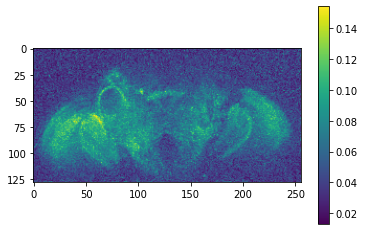

In [118]:
plt.imshow(maxi_projection.T)
plt.colorbar()

In [120]:
### corr with Z
shifted_beh_z = np.roll(fictrac['Z'][:,0],8)

corrs_z = []
for x in range(256):
    for y in range(128):
        for z in range(49):
            corrs_z.append(scipy.stats.pearsonr(neural[x,y,z,:], shifted_beh_z)[0])

In [121]:
whole_corr_z = np.reshape(np.asarray(corrs_z),(256,128,49))

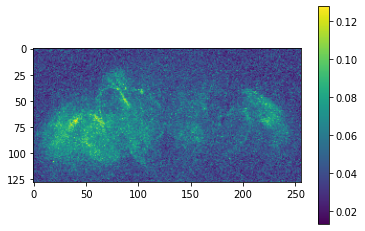

In [122]:
maxi_projection_z = np.max(whole_corr_z, axis = 2)
plt.imshow(maxi_projection_z.T)
plt.colorbar()

# load neural

In [107]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [108]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [109]:
fixed = brainsss.load_fda_meanbrain()

In [110]:
atlas = brainsss.load_roi_atlas()

In [111]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [112]:
bin_start = -500; bin_end = 2000; bin_size = 100
neural_bins = np.arange(bin_start,bin_end,bin_size)

# STA wrapped

In [22]:
all_explosions = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(24):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

ve_no_0
STA 1.249084711074829
Warps 64.76805806159973
Explosion 46.55503797531128
ve_no_180
STA 1.2412827014923096
Warps 68.53913736343384
Explosion 46.73633933067322
ve_0
STA 1.1893815994262695
Warps 81.47812247276306
Explosion 46.84498572349548
ve_180
STA 1.2154333591461182
Warps 121.78571557998657
Explosion 46.555198192596436


In [140]:
a = np.asarray(trial_idss)
a


array([[ 2,  9, 13, 16, 23, 27, 30, 38, 42, 49, 52, 59, 61, 69, 73, 76],
       [ 1,  7, 14, 19, 24, 28, 34, 35, 44, 45, 51, 55, 62, 65, 70, 75],
       [ 3,  6, 12, 15, 21, 26, 31, 39, 40, 47, 54, 56, 64, 66, 71, 79],
       [ 4,  5, 10, 17, 22, 29, 33, 36, 43, 46, 53, 57, 63, 67, 74, 78],
       [ 0,  8, 11, 18, 20, 25, 32, 37, 41, 48, 50, 58, 60, 68, 72, 77]])

In [166]:
n_50 = trial_idss[4]
type(n_50)
n_50_times = []
for elem in n_50:
    n_50_time = stimulus_start_times[elem]
    n_50_times.append(n_50_time)
len(n_50_times)

16

In [167]:
stimulus_start_times[2]

5730

In [168]:
t0 = time.time()
STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = n_50_times,
                                       neural_bins = neural_bins)
print(F'STA {time.time()-t0}')

reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
#STA_brain = STA_brain[:,np.newaxis,:,:]  
    
t0 = time.time()
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_223', fixed=fixed, anat_to_mean_type='myr')
print(F'Warps {time.time()-t0}')
    
explosions = []
t0 = time.time()

input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warps[0][:,:,::-1]
vmax = 0.5
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')
explosions

/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in true_divide



STA 0.24091410636901855
Warps 10.558084964752197
Explosion 1.4972963333129883


[array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])]

In [125]:
np.shape(explosions)

(1, 500, 500, 3)

In [114]:
trial_idss
t0 = time.time()
STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
print(F'STA {time.time()-t0}')

reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
STA_brain = STA_brain[:,np.newaxis,:,:]  
t0 = time.time()
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
print(F'Warps {time.time()-t0}')
    
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[0][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')
explosions

TypeError: make_STA_brain() missing 1 required positional argument: 'event_times_list'

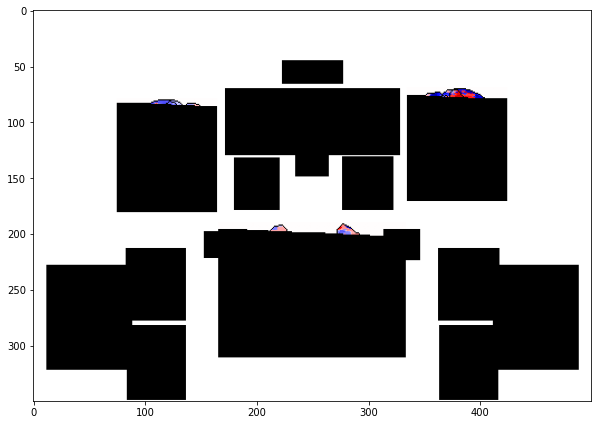

In [169]:
plt.figure(figsize=(10,10))
plt.imshow(explosions[0][150:,:]) #this was made with cmap=hot

In [131]:
from shutil import copyfile
from xml.etree import ElementTree as ET
from lxml import etree, objectify
from openpyxl import Workbook
from openpyxl import load_workbook

In [135]:
range(215,223)

range(215, 223)

In [136]:
for fly in range(215,223):
    temp = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/func_0/'
    copy_fictrac(temp,user='brezovec')

Transfering file......................................................fly_215/func_0/fictrac/fictrac-20220727_153401.dat
Transfering file......................................................fly_216/func_0/fictrac/fictrac-20220727_165051.dat
Transfering file......................................................fly_217/func_0/fictrac/fictrac-20220728_164256.dat
Transfering file......................................................fly_218/func_0/fictrac/fictrac-20220803_132027.dat
Transfering file......................................................fly_219/func_0/fictrac/fictrac-20220803_142225.dat
Transfering file......................................................fly_220/func_0/fictrac/fictrac-20220804_163345.dat
Transfering file......................................................fly_221/func_0/fictrac/fictrac-20220804_174933.dat
Transfering file......................................................fly_222/func_0/fictrac/fictrac-20220804_184427.dat


In [125]:
def copy_fictrac(destination_region, user):
    #fictrac_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/imports/fictrac'

    if user == 'brezovec':
        user = 'luke'
    if user == 'yandanw':
        user = 'luke'
    if user == 'ilanazs':
        user = 'luke'
    fictrac_folder = os.path.join("/oak/stanford/groups/trc/data/fictrac",user)
    fictrac_destination = os.path.join(destination_region, 'fictrac')

    # Find time of experiment based on functional.xml
    true_ymd, true_total_seconds = get_expt_time(os.path.join(destination_region,'imaging'))
    #printlog(f'true_ymd: {true_ymd}; true_total_seconds: {true_total_seconds}')

    # Find .dat file of 1) correct-ish time, 2) correct-ish size
    correct_date_and_size = []
    time_differences = []
    for file in os.listdir(fictrac_folder):

        # must be .dat file
        if '.dat' not in file:
            continue

        # Get datetime from file name
        datetime = file.split('-')[1][:-4]
        test_ymd = datetime.split('_')[0]
        test_time = datetime.split('_')[1]
        test_hour = test_time[0:2]
        test_minute = test_time[2:4]
        test_second = test_time[4:6]
        test_total_seconds = int(test_hour) * 60 * 60 + \
                             int(test_minute) * 60 + \
                             int(test_second)

        # Year/month/day must be exact
        if true_ymd != test_ymd:
            continue
        #printlog('Found file from same day: {}'.format(file))

        # Must be correct size
        fp = os.path.join(fictrac_folder, file)
        file_size = os.path.getsize(fp)
        if file_size < 1000000: #changed to 1MB to accomidate 1 min long recordings. #30000000: #30MB
            #width = 120
            #printlog(F"Found correct .dat file{file:.>{width-23}}")
            #datetime_correct = datetime
            #break
            continue

        # get time difference from expt
        time_difference = np.abs(true_total_seconds - test_total_seconds)
        # Time must be within 10min
        if time_difference > 10 * 60:
            continue

        # if correct date and size append to list of potential file
        correct_date_and_size.append(file)
        time_differences.append(time_difference)

    # now that we have all potential files, pick the one with closest time
    # except clause will happen if empty list
    try:
        datetime_correct = correct_date_and_size[np.argmin(time_differences)]
    except:
        width = 120
        print(F"{'   No fictrac data found --- continuing without fictrac data   ':*^{width}}")
        return

    # Collect all fictrac files with correct datetime
    correct_time_files = [file for file in os.listdir(fictrac_folder) if datetime_correct in file]

    # correct_time_files = []
    # for file in os.listdir(fictrac_folder):
    #     if datetime_correct in file:
    #         correct_time_files.append(file)


    #printlog('Found these files with correct times: {}'.format(correct_time_files))
    ##sys.stdout.flush()

    # Now transfer these 4 files to the fly
    os.mkdir(fictrac_destination)
    for file in correct_time_files:
        width=120
        target_path = os.path.join(fictrac_destination, file)
        source_path = os.path.join(fictrac_folder, file)
        to_print = ('/').join(target_path.split('/')[-4:])
        print(f'Transfering file{to_print:.>{width-16}}')
        #printlog('Transfering {}'.format(target_path))
        ##sys.stdout.flush()
        copyfile(source_path, target_path)

    ### Create empty xml file.
    # Update this later
    root = etree.Element('root')
    fictrac = objectify.Element('fictrac')
    root.append(fictrac)
    objectify.deannotate(root)
    etree.cleanup_namespaces(root)
    tree = etree.ElementTree(fictrac)
    with open(os.path.join(fictrac_destination, 'fictrac.xml'), 'wb') as file:
        tree.write(file, pretty_print=True)

In [127]:
def get_expt_time(directory):
    ''' Finds time of experiment based on functional.xml '''
    xml_file = os.path.join(directory, 'functional.xml')
    _, _, datetime_dict = get_datetime_from_xml(xml_file)
    true_ymd = datetime_dict['year'] + datetime_dict['month'] + datetime_dict['day']
    true_total_seconds = int(datetime_dict['hour']) * 60 * 60 + \
                         int(datetime_dict['minute']) * 60 + \
                         int(datetime_dict['second'])

    ##print('dict: {}'.format(datetime_dict))
    ##print('true_ymd: {}'.format(true_ymd))
    ##print('true_total_seconds: {}'.format(true_total_seconds))
    ##sys.stdout.flush()
    return true_ymd, true_total_seconds

In [129]:
def get_datetime_from_xml(xml_file):
    ##print('Getting datetime from {}'.format(xml_file))
    ##sys.stdout.flush()
    tree = ET.parse(xml_file)
    root = tree.getroot()
    datetime = root.get('date')
    # will look like "4/2/2019 4:16:03 PM" to start

    # Get dates
    date = datetime.split(' ')[0]
    month = date.split('/')[0]
    day = date.split('/')[1]
    year = date.split('/')[2]

    # Get times
    time = datetime.split(' ')[1]
    hour = time.split(':')[0]
    minute = time.split(':')[1]
    second = time.split(':')[2]

    # Convert from 12 to 24 hour time
    am_pm = datetime.split(' ')[-1]
    if am_pm == 'AM' and hour == '12':
        hour = str(00)
    elif am_pm == 'AM':
        pass
    elif am_pm == 'PM' and hour == '12':
        pass
    else:
        hour = str(int(hour) + 12)

    # Add zeros if needed
    if len(month) == 1:
        month = '0' + month
    if len(day) == 1:
        day = '0' + day
    if len(hour) == 1:
        hour = '0' + hour

    # Combine
    datetime_str = year + month + day + '-' + hour + minute + second
    datetime_int = int(year + month + day + hour + minute + second)
    datetime_dict = {'year': year,
                     'month': month,
                     'day': day,
                     'hour': hour,
                     'minute': minute,
                     'second': second}

    return datetime_str, datetime_int, datetime_dict